In [35]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)

# local functions
import diff_nmf
import grid_search
import data_generator
import nmf
from diff_nmf import diff_nmf
from grid_search import gridSearcher
from data_generator import gen_decomposition, gen_laplacian, add_noise, train_mask
from nmf import nmf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 1

## Generate Synthetic Data

As a first example here is how I might generate a synthetic X and V with shape 250 x 50 with rank 4. Also included is generation of a random graph + generation of diffusion with beta parameter equal to 1.

In [37]:
# defined parameters for data
n = 250
m = 50
rank = 4
rand_state = 1729

In [38]:
W,H = gen_decomposition(n,m,rank,state=rand_state)

Text(445.23636363636354, 0.5, 'Basis')

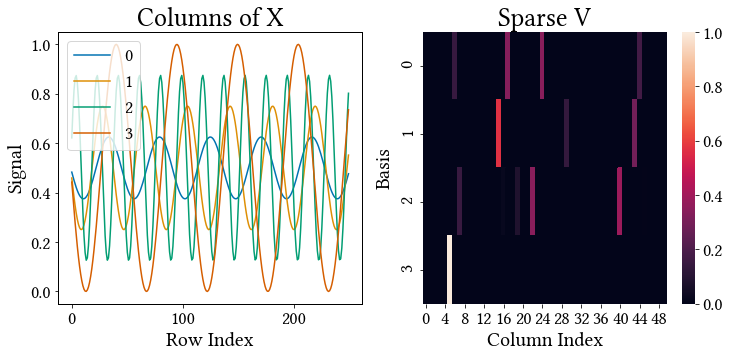

In [39]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
W.plot(ax=ax[0])
ax[0].set_title("Columns of X", fontsize = 26)
ax[0].set_xlabel("Row Index", fontsize = 20)
ax[0].set_ylabel("Signal", fontsize = 20)
sns.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Sparse V", fontsize = 26)
ax[1].set_xlabel("Column Index", fontsize = 20)
ax[1].set_ylabel("Basis", fontsize = 20)

In [40]:
# Laplacian:
G, lapl = gen_laplacian(size = m, radius = 0.30, state = rand_state)

# Diffusion Kernel
beta = 5
I = np.identity(np.dot(W,H).shape[1])
K = np.linalg.inv(I + beta*lapl)
D = np.dot(W, np.dot(H,K))

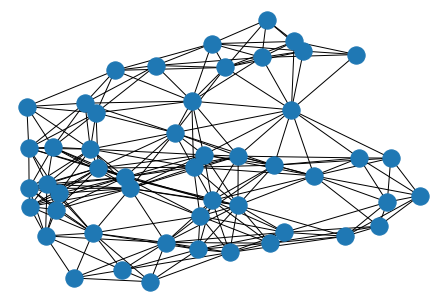

In [41]:
nx.draw(G)

Text(0.5, 1.0, 'Subset of generated data')

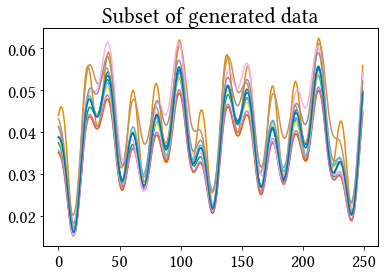

In [42]:
pd.DataFrame(D).loc[:,10:20].plot(legend=False)
plt.title("Subset of generated data")

## Initial Test

Without any modification to the data, and knowing the true parameter, how well can NMF and diffusion-NMF recover the original X and V??

In [43]:
# NMF test
nmfer = nmf(n_components = 4, mask = None, n_iter = 100000, tol = 1e-9)
W_out, H_out = nmfer.fit_transform(D)

Text(0.5, 1.0, 'NMF reconstructed V')

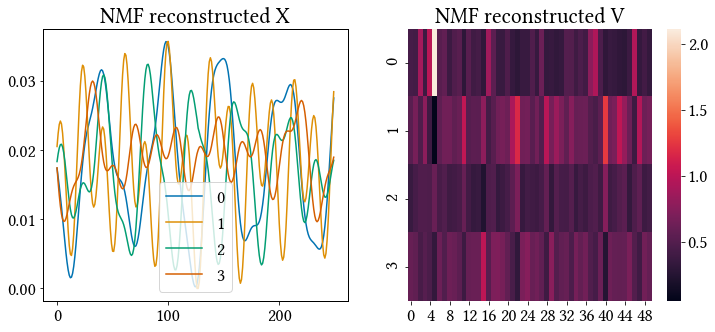

In [44]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
pd.DataFrame(W_out).plot(title = "NMF reconstructed X", ax = ax[0])
sns.heatmap(H_out, square = False, cbar = True, ax = ax[1])
ax[1].set_title("NMF reconstructed V")

Note that because the data was made by combining a random X,V with a diffusion through a laplacian (i.e. made by multiplying X,V,K), standard NMF does not do well in recovering the original waves. What's more is that the coefficient matrix, H, outputted is not very sparse and does not seem to distinguish locations. 

*** Note that columns/rows of W,H are out of order from what's seen in the original X,V above ***

In [45]:
# diffusion NMF test
differ = diff_nmf(n_components = 4, kernel = K, mask = None, n_iter = 100000, tol = 1e-9)
X,V = differ.fit_transform(D)

Max iterations reached, increase to converge on given tolerance


Text(0.5, 1.0, 'D-NMF reconstructed V')

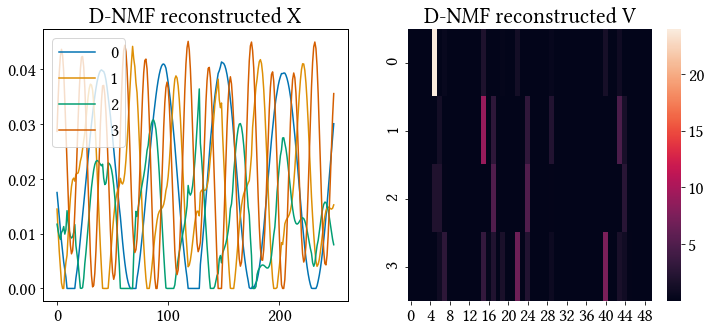

In [46]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
pd.DataFrame(X).plot(title = "D-NMF reconstructed X", ax = ax[0])
sns.heatmap(V, square = False, cbar = True, ax = ax[1])
ax[1].set_title("D-NMF reconstructed V")

Here, diffusion NMF is better able to capture the original waves and is better at distinguishing a sparse set of origin points in the coefficient matrix. 

*** Again, columns/rows are out of order from what's seen in the original X,V above ***

## Data modifications

In order to make the test setting more realistic and to avoid overfitting, I will modify the generated data as follows:

1. Randomly add noise to entries in the data to simulate noisy real-world data
2. Hide entries for a train/test procedure so as to avoid an overly fit solution

Look for documentation in data_generator.py

Text(0.5, 1.0, 'Subset of Data with Noise added')

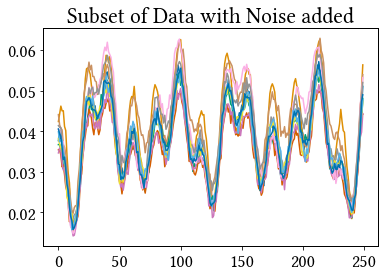

In [47]:
# Add noise
noise_D = add_noise(D, 0.001)
pd.DataFrame(noise_D).loc[:,10:20].plot(legend=False)
plt.title("Subset of Data with Noise added")

In [48]:
# Hide Entries
hidden_mask = train_mask(noise_D, 0.2)

## Error Baseline

Now with these processes for creating test-ready data, I can analyze how both NMF and D-NMF perform as the parameters (rank and beta (spread parameter)) used for solving are changed. To do so I will look at relative errors and compare them with the baseline error that comes from adding noise to the data. 

In [49]:
# this function simply repeats the process of randomly adding noise / hiding entries for a range of tests
# it serves to compute the ground, baseline error that comes from simply adding noise.

def ground_error(data, tests, n_avg = 10, noise_base = 0.001, percent_hide = 0.2):
    ground_error = np.zeros(tests)
    ground_std = np.zeros(tests)
    
    for t in range(tests):
        g_err = np.zeros(n_avg)
        for n in range(n_avg):
            noise_D = add_noise(data, noise_base)
            hidden_mask = train_mask(noise_D, 0.2)
            g_err[n] = np.linalg.norm((1 - hidden_mask) * (noise_D - data)) / np.linalg.norm((1 - hidden_mask) * data)
            
        ground_error[t] = g_err.mean()
        ground_std[t] = g_err.std()
        
    return ground_error, ground_std

In [50]:
# Holding the true rank at 4 we can compute the error results for ground error, nmf error, and d-nmf error 
# using a range of changing rank parameters. For this experiment all beta parameters used are equal to the true
# value of 1.

noise_base = 0.001
ranks = list(range(1,15))
betas = np.array([5])
n_avg = 10

ground, ground_std = ground_error(D, len(ranks), n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)

nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
nmf_res = nG.grid_search(ranks, betas)

dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
diff_res = dG.grid_search(ranks, betas)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  7.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 20.5min finished


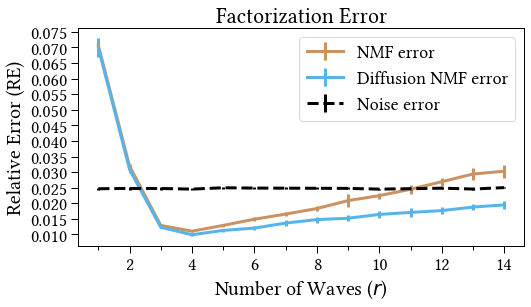

In [51]:
ranks = list(range(1,15))
c_pal = sns.color_palette("colorblind", 10)
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.005))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, nmf_res["relative error"], nmf_res["std error"], label = "NMF error", linewidth = 3, color = c_pal[5])
ax.errorbar(ranks, diff_res["relative error"], diff_res["std error"], label = "Diffusion NMF error", linewidth = 3, color = c_pal[9])
ax.errorbar(ranks, ground, ground_std, color = "k", linestyle = "--", label = "Noise error", linewidth = 3)
ax.set_xlabel(r"Number of Waves ($r$)", fontsize = 20)
ax.set_ylabel("Relative Error (RE)", fontsize = 20)
ax.set_title("Factorization Error", fontsize = 22)
plt.legend() 


In [52]:
# Same thing but now testing beta values and holding true rank at 4:
ranks = [4]
#betas = np.linspace(0.1,2,15)
betas = np.linspace(0,10,20)
n_avg = 10

ground2, ground_std2 = ground_error(D, len(betas), n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)

nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
nmf_res2 = nG.grid_search(ranks, betas)

dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
diff_res2 = dG.grid_search(ranks, betas)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 25.7min finished


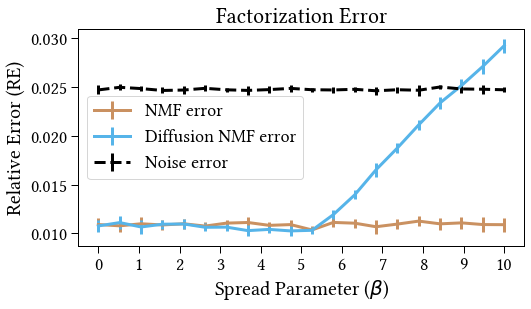

In [54]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.005))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(betas, nmf_res2["relative error"], nmf_res2["std error"], label = "NMF error", linewidth = 3, color = c_pal[5])
ax.errorbar(betas, diff_res2["relative error"], nmf_res2["std error"], label = "Diffusion NMF error", linewidth = 3, color = c_pal[9])
ax.errorbar(betas, ground2, ground_std2, color = "k", linestyle = "--", label = "Noise error", linewidth = 3)
ax.set_xlabel(r"Spread Parameter ($\beta$)", fontsize = 20)
ax.set_ylabel("Relative Error (RE)", fontsize = 20)
ax.set_title("Factorization Error", fontsize = 22)
plt.legend()

## Grid Search for parameters

To extend the previous analysis I could also jointly search for the correct rank, beta parameters. Doing so would only require I use the same functions used in the previous example. Please look to grid_search.py for more information. Because the grid search process is quite expensive and the previous section covered how to use the functions, I will only show images of what the outcomes look like and leave the heavy lifting to a more powerful computer.

In [55]:
grid_data = pd.read_csv("synthetic_grid_search.csv", index_col = 0)

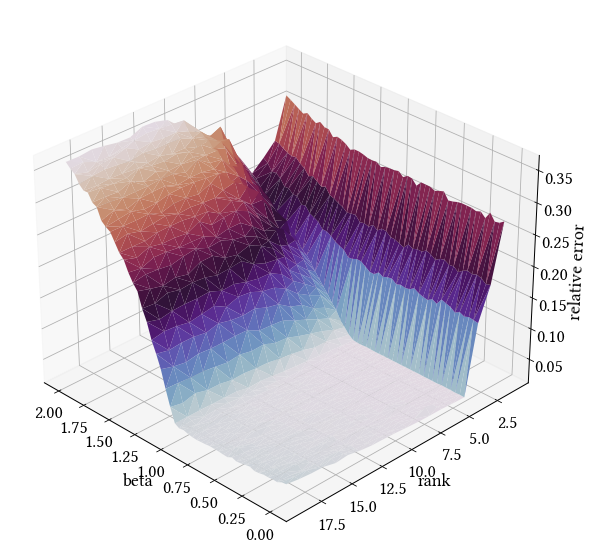

In [56]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(grid_data['beta'], grid_data['rank'], grid_data['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,135)